In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, integrate, special
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()

In [3]:
# df_pre_lockdown = df[(df["started_at"] < "2020-03-21")].dropna()
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

In [167]:
# 各dfの要素数
print("df_p1:", len(df_p1))
print("df_p2:", len(df_p2))
print("df_p3:", len(df_p3))
print("df_p4:", len(df_p4))
print("df_p4_1:", len(df_p4_1))
print("df_p4_2:", len(df_p4_2))
print("df_lockdown:", len(df_lockdown))
print("df_resi1:", len(df_resi1))
print("df_resi2:", len(df_resi2))
print("df_lockdown_relax:", len(df_lockdown_relax))
print("df_after_lockdown:", len(df_after_lockdown))
print("df_aft_eto:", len(df_aft_eto))


df_p1: 284630
df_p2: 2341165
df_p3: 240416
df_p4: 12317142
df_p4_1: 4461797
df_p4_2: 7855345
df_lockdown: 284630
df_resi1: 2341165
df_resi2: 144682
df_lockdown_relax: 147223
df_after_lockdown: 12488442
df_aft_eto: 150016


In [169]:
node, edge, time = return_nm(df_resi2)

In [170]:
print("node:", node)

node: [745 821 889 897 880 956 981 963 933 860 826 844 819 766 640]


In [168]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        # df_tmpのstart_station_idをstr型に変換してからユニークな値を取得
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
node_lockdown, edge_lockdown, timestamp_lockdown = return_nm(df_lockdown)
node_resi1, edge_resi1, timestamp_resi1 = return_nm(df_resi1)
node_lockdown_relax, edge_lockdown_relax, timestamp_lockdown_relax = return_nm(df_lockdown_relax)
node_resi2, edge_resi2, timestamp_resi2 = return_nm(df_resi2)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown = return_nm(df_after_lockdown)
node_aft_eto, edge_aft_eto, timestamp_aft_eto = return_nm(df_aft_eto)

In [6]:
lockdown = pd.DataFrame({'timestamp': timestamp_lockdown, 'node': node_lockdown, 'edge': edge_lockdown})
resi1 = pd.DataFrame({'timestamp': timestamp_resi1, 'node': node_resi1, 'edge': edge_resi1})
resi2 = pd.DataFrame({'timestamp': timestamp_resi2, 'node': node_resi2, 'edge': edge_resi2})
lockdown_relax = pd.DataFrame({'timestamp': timestamp_lockdown_relax, 'node': node_lockdown_relax, 'edge': edge_lockdown_relax})
after_lockdown = pd.DataFrame({'timestamp': timestamp_after_lockdown, 'node': node_after_lockdown, 'edge': edge_after_lockdown})
aft_eto = pd.DataFrame({'timestamp': timestamp_aft_eto, 'node': node_aft_eto, 'edge': edge_aft_eto})

In [7]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N

In [127]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [9]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N

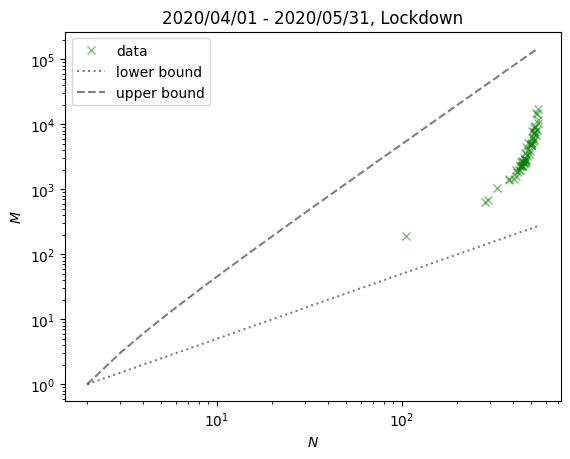

In [55]:
plt.Figure(figsize=(14,7))

N = lockdown['node']
M = lockdown['edge']

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2020/05/31, Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

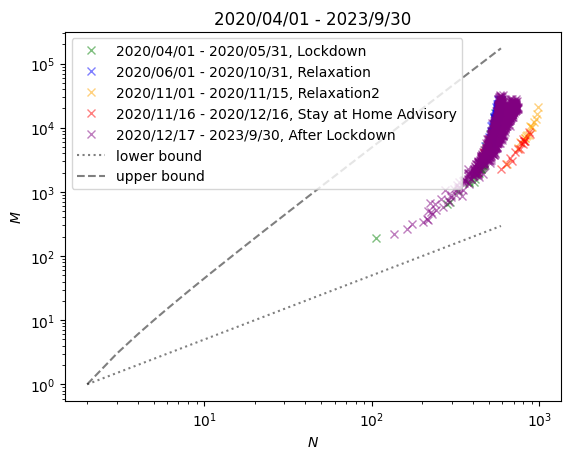

In [52]:
plt.Figure(figsize=(18,9))
plt.rcParams["font.size"] = 10

lock_N = lockdown['node']
lock_M = lockdown['edge']

resi1_N = resi1['node']
resi1_M = resi1['edge']

resi2_N = resi2['node'] 
resi2_M = resi2['edge']

lockdown_relax_N = lockdown_relax['node']
lockdown_relax_M = lockdown_relax['edge']

after_lockdown_N = after_lockdown['node']
after_lockdown_M = after_lockdown['edge']


x = np.arange(2, np.max(resi1_N))
y = np.arange(1, np.max(resi1_M))

plt.plot(lock_N, lock_M, "x", c="green", alpha=0.5, label="2020/04/01 - 2020/05/31, Lockdown")
plt.plot(resi1_N, resi1_M, "x", c="blue", alpha=0.5, label="2020/06/01 - 2020/10/31, Relaxation")
plt.plot(resi2_N, resi2_M, "x", c="orange", alpha=0.5, label="2020/11/01 - 2020/11/15, Relaxation2")
plt.plot(lockdown_relax_N, lockdown_relax_M, "x", c="red", alpha=0.5, label="2020/11/16 - 2020/12/16, Stay at Home Advisory")
plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2023/9/30, After Lockdown")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2023/9/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

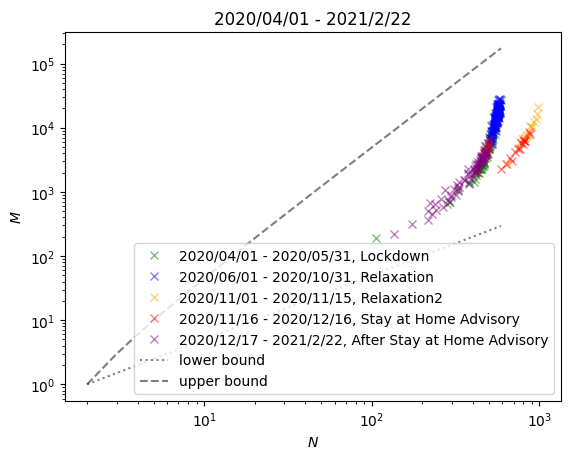

In [53]:
plt.Figure(figsize=(14,7))

lock_N = lockdown['node']
lock_M = lockdown['edge']

resi1_N = resi1['node']
resi1_M = resi1['edge']

resi2_N = resi2['node'] 
resi2_M = resi2['edge']

lockdown_relax_N = lockdown_relax['node']
lockdown_relax_M = lockdown_relax['edge']

after_lockdown_N = after_lockdown['node']
after_lockdown_M = after_lockdown['edge']

aft_eto_N = aft_eto['node']
aft_eto_M = aft_eto['edge']


x = np.arange(2, np.max(resi1_N))
y = np.arange(1, np.max(resi1_M))

plt.plot(lock_N, lock_M, "x", c="green", alpha=0.5, label="2020/04/01 - 2020/05/31, Lockdown")
plt.plot(resi1_N, resi1_M, "x", c="blue", alpha=0.5, label="2020/06/01 - 2020/10/31, Relaxation")
plt.plot(resi2_N, resi2_M, "x", c="orange", alpha=0.5, label="2020/11/01 - 2020/11/15, Relaxation2")
plt.plot(lockdown_relax_N, lockdown_relax_M, "x", c="red", alpha=0.5, label="2020/11/16 - 2020/12/16, Stay at Home Advisory")
#plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2021/4/22, After Emergency Travel Order")
plt.plot(aft_eto_N, aft_eto_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2021/2/22, After Stay at Home Advisory")
# plt.plot(after_lockdown_N, after_lockdown_M, "x", c="purple", alpha=0.5, label="2020/12/17 - 2023/9/30, After Lockdown")
#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2021/2/22")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

## アクティビティの推計
### Lockdown期間
2020/4~2020/5/31

In [78]:
params, _ = optimize.curve_fit(Model1, lockdown['edge'], lockdown['node'], p0=[0.05])
print(params[0])

0.17461087202683556


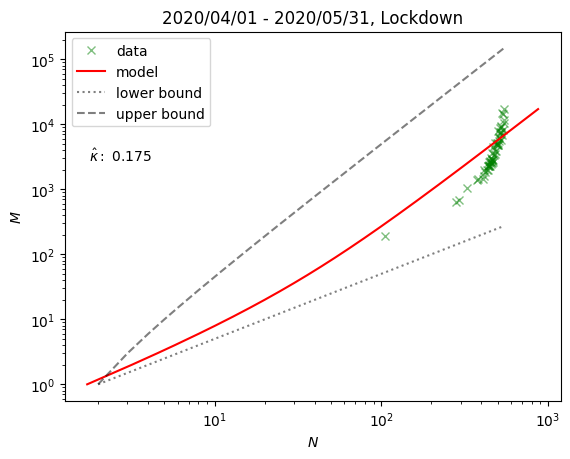

In [61]:
plt.Figure(figsize=(14,7))

N = lockdown['node']
M = lockdown['edge']
kappa = params[0]
kappa = round(kappa, 3)

x = np.arange(2, np.max(N))
y = np.arange(1, np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.5, label="data")
plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/04/01 - 2020/05/31, Lockdown")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


[0.00668937 0.01396097]


In [70]:
params, _ = optimize.curve_fit(Model2, lockdown['edge'], lockdown['node'], p0=[0.01])
print(params[0])

0.7930517284479657


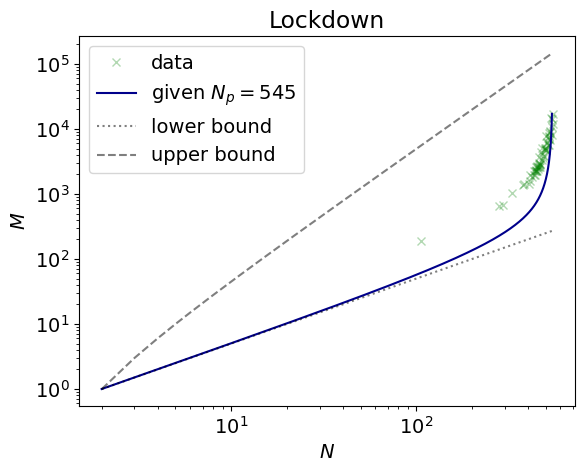

In [75]:
kappa = params[0]
kappa = round(kappa, 3)

# plt.rcParams["font.size"]=14
Np = np.max(N)
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")
plt.plot(Model2(y,Np), y, "-", c="darkblue", label = r"given $N_p=$"+str(Np))
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Lockdown")
plt.legend()

In [160]:
N = lockdown['node']
M = lockdown['edge']

Np = 596 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, lockdown['edge'], lockdown['node'], p0=[0.9, 0.9])
print(params)
alpha = params[0]
beta = params[1]

[0.47089243 9.707239  ]


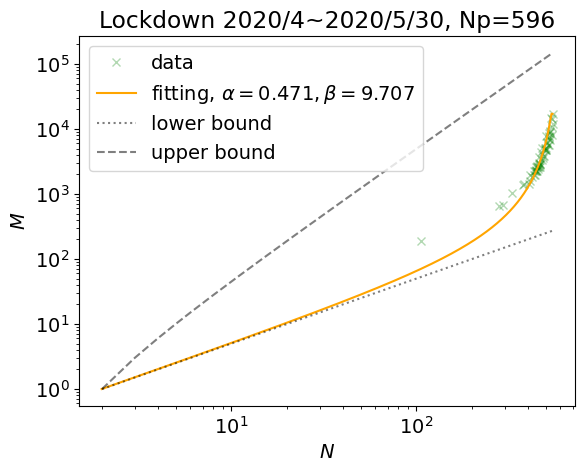

In [135]:
# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Lockdown 2020/4~2020/5/30, Np="+str(Np))
plt.legend()

In [93]:
N = lockdown['node']
M = lockdown['edge']

Np = 596 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, lockdown['edge'], lockdown['node'], p0=[1, 1])
print(params)
alpha = params[0]
beta = params[1]

[0.47089493 9.70729278]


In [161]:
Np = 673 # histrical dataから求めたNp
params_resi1, _ = optimize.curve_fit(Model3_fixed, resi1['edge'], resi1['node'], p0=[0.5, 3])
print(params_resi1)

[0.35129455 5.33725394]


In [101]:
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/1232684190.py:5: RuntimeWarning: divide by zero encountered in power
  return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)


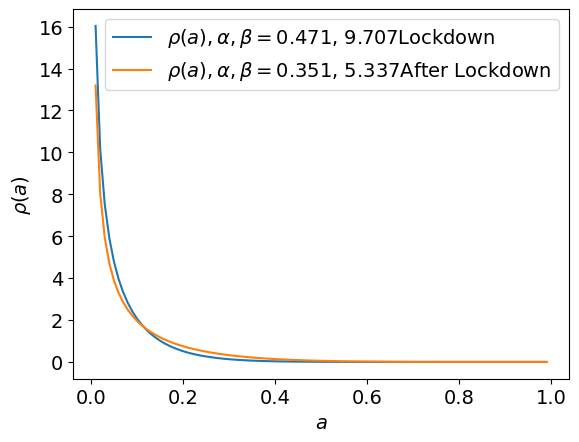

In [168]:
# 0から1まで0.01刻みでaを生成
a = np.arange(0, 1, 0.01)
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha,\beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"Lockdown")
plt.plot(a, rho(a, alpha1, beta1), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha1, 3))+", "+str(round(beta1, 3))+"After Lockdown")
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
#plt.title(r"$\alpha^{*}=$"+str(round(alpha, 3))+r", $\beta^{*}=$"+str(round(beta, 3)))
plt.legend()
plt.show()

## Lockdownと自宅待機勧告の間

In [150]:
Np = 673 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, resi1['edge'], resi1['node'], p0=[0.5, 3])
print(params)

[0.35129455 5.33725394]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/3128648371.py:5: RuntimeWarning: divide by zero encountered in power
  return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)


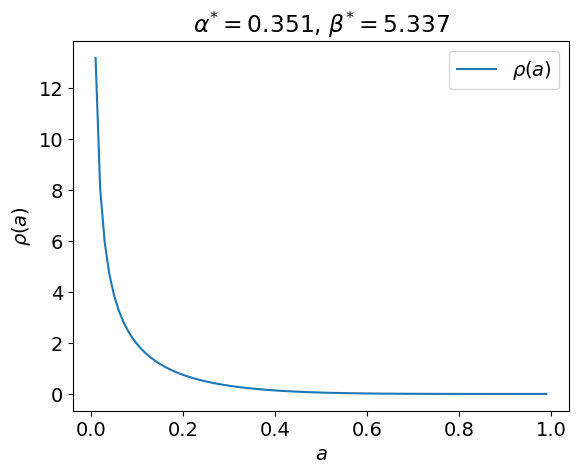

In [151]:
# 0から1まで0.01刻みでaを生成
alpha = params[0]
beta = params[1]

a = np.arange(0, 1, 0.01)
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a)$")
plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
plt.title(r"$\alpha^{*}=$"+str(round(alpha, 3))+r", $\beta^{*}=$"+str(round(beta, 3)))
plt.legend()
plt.show()

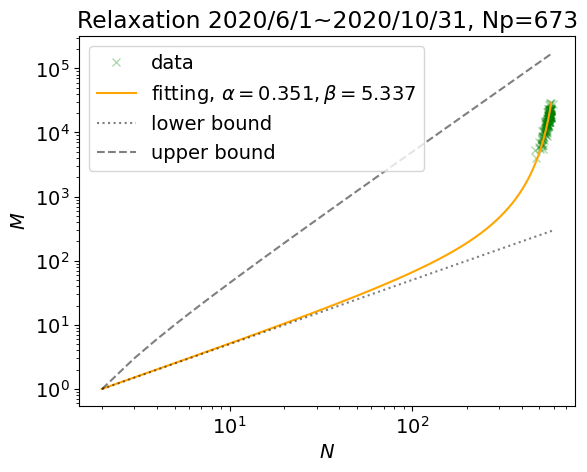

In [112]:
# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
N = resi1['node']
M = resi1['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

alpha = params[0]
beta = params[1]

# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)

"""
alpha = 0.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="red", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 1
beta = 0.048
plt.plot(Model3(y), y, "-", c="darkblue", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 2
beta = 0.048
plt.plot(Model3(y), y, "-", c="green", label=f"given $\\alpha={alpha}, \\beta={beta}$")

alpha = 2.5
beta = 0.048
plt.plot(Model3(y), y, "-", c="purple", label=f"given $\\alpha={alpha}, \\beta={beta}$")


alpha = 3
beta = 0.01
plt.plot(Model3(y), y, "-", c="black", label=f"given $\\alpha={alpha}, \\beta={beta}$")
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Relaxation 2020/6/1~2020/10/31, Np="+str(Np))
plt.legend()

## 2020/11~直前

In [138]:
Np = 670 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, resi2['edge'], resi2['node'], p0=[0.3, 0.1], maxfev=10000)
print(params)

[ 8.04830605 29.65290462]


In [139]:
# Model1での推定
params1, _ = optimize.curve_fit(Model1, resi2['edge'], resi2['node'], p0=[0.01])
print(params1[0])

0.10223950944291488


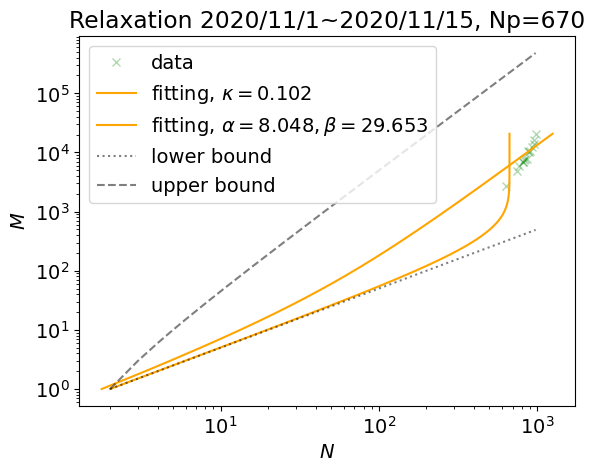

In [141]:
alpha = params[0]
beta = params[1]
kappa = params1[0]

# alpha = round(alpha, 5)
# beta = round(beta, 5)

plt.Figure(figsize=(14,7))
N = resi2['node']
M = resi2['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

alpha = params[0]
beta = params[1]

# model
plt.plot(Model1(y, kappa=kappa), y, "-", c="orange", label=f"fitting, $\\kappa={round(kappa, 3)}$")
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)


# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Relaxation 2020/11/1~2020/11/15, Np="+str(Np))
plt.legend()

## 自宅待機勧告

In [152]:
# df_lockdown_relaxについて分析
Np = 681 # histrical dataから求めたNp

In [153]:
params, _ = optimize.curve_fit(Model3_fixed, lockdown_relax["edge"], lockdown_relax["node"], p0=[0.5, 3])
print(params)

[ 0.7621282  47.00474954]


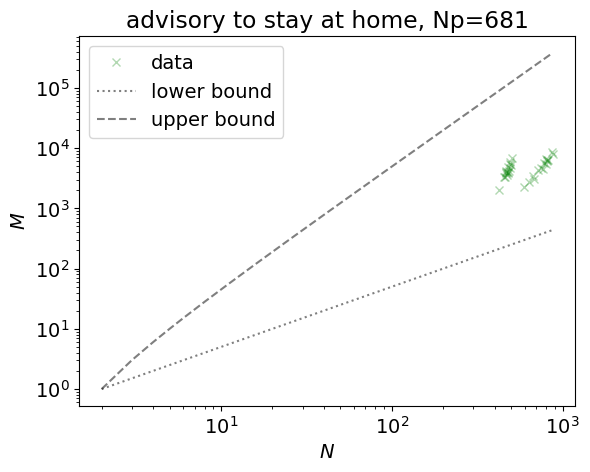

In [156]:
alpha = params[0]
beta = params[1]

plt.Figure(figsize=(14,7))
N = lockdown_relax['node']
M = lockdown_relax['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
# plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
# plt.text(0.05, 0.55, r'$\hat{\alpha}:$ ' + str(round(alpha, 3)), transform=plt.gca().transAxes)
# plt.text(0.05, 0.50, r'$\hat{\beta}:$ ' + str(round(beta, 3)), transform=plt.gca().transAxes)


# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("advisory to stay at home, Np="+str(Np))
plt.legend()

In [170]:
print(node_lockdown_relax)

[813 779 815 872 869 794 718 801 592 635 681 766 812 747 666 465 479 491
 492 500 473 467 476 494 502 457 426 483 480 464 454]


In [10]:
# node_lockdown_relaxを14個ずつに分割
node_lockdown_relax_1 = node_lockdown_relax[:15]
node_lockdown_relax_2 = node_lockdown_relax[15:31]

In [178]:
node_lockdown_relax_1

array([813, 779, 815, 872, 869, 794, 718, 801, 592, 635, 681, 766, 812,
       747, 666])

In [179]:
node_lockdown_relax_2

array([465, 479, 491, 492, 500, 473, 467, 476, 494, 502, 457, 426, 483,
       480, 464, 454])

In [11]:
lockdown_relax_1 = pd.DataFrame({'timestamp': timestamp_lockdown_relax[:15], 'node': node_lockdown_relax_1, 'edge': edge_lockdown_relax[:15]})
lockdown_relax_2 = pd.DataFrame({'timestamp': timestamp_lockdown_relax[15:31], 'node': node_lockdown_relax_2, 'edge': edge_lockdown_relax[15:31]})

In [25]:
# lockdown_relax_1について分析
Np = 677 # histrical dataから求めたNp

params, _ = optimize.curve_fit(Model3_fixed, lockdown_relax_1["edge"], lockdown_relax_1["node"], p0=[2.5, 0.5], maxfev=50000)
print(params)
alpha = params[0]
beta = params[1]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:3: RuntimeWarning: overflow encountered in scalar power
  f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


[  5.55106438 162.02927136]


In [16]:
params, _ = optimize.curve_fit(Model2, lockdown_relax_1["edge"], lockdown_relax_1["node"], p0=[0.1], maxfev=10000)
print(params)

[0.79565813]


In [44]:
params, _ = optimize.curve_fit(Model1, lockdown_relax_1["edge"], lockdown_relax_1["node"], p0=[0.01], maxfev=10000)
print(params)

[0.06722551]


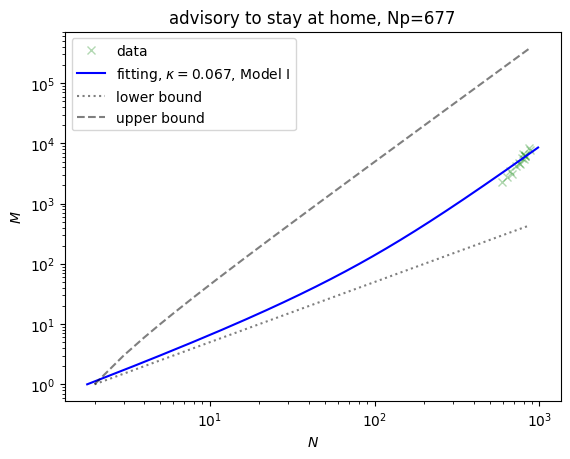

In [46]:
plt.Figure(figsize=(14,7))
N = lockdown_relax_1['node']
M = lockdown_relax_1['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
"""
alpha = 9
beta = 25
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(Model2(y, Np), y, "-", c="red", label=f"fitting, $N_p={Np}$, Model II")
"""

plt.plot(Model1(y, kappa=0.067), y, "-", c="blue", label=f"fitting, $\\kappa=0.067$, Model I")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("advisory to stay at home, Np="+str(Np))
plt.legend()

In [41]:
# 各モデルの残差を計算
def residual1(params, x, y):
    return y - Model1(x, kappa=params[0])

def residual2(params, x, y):
    return y - Model2(x, Np=params[0])

def residual3(params, x, y):
    return y - Model3_fixed(x, alpha=params[0], beta=params[1])

# 各モデルの残差で最も小さいものを採用
def residual(params, x, y):
    res1 = residual1(params, x, y)
    res2 = residual2(params, x, y)
    res3 = residual3(params, x, y)
    return res1 + res2 + res3

# lockdown_relax_1について分析
Np = 677 # histrical dataから求めたNp

print("Residual of Model I")
resi_model1 = residual1([0.067], lockdown_relax_1["edge"], lockdown_relax_1["node"])
print("Residual of Model II")
resi_model2 = residual2([Np], lockdown_relax_1["edge"], lockdown_relax_1["node"])
print("Residual of Model III")
resi_model3 = residual3([alpha, beta], lockdown_relax_1["edge"], lockdown_relax_1["node"])




Residual of Model I
Residual of Model II
Residual of Model III


In [56]:
# residual3での推定
params = optimize.least_squares(residual3, [10, 20], args=(lockdown_relax_1["edge"], lockdown_relax_1["node"]), max_nfev=10000)
print(params)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.362e+02  1.023e+02 ...  7.059e+01 -9.012e+00]
           x: [ 5.440e+00  6.728e+01]
        cost: 96401.6281791472
         jac: [[-1.479e-01  4.247e-04]
               [-1.865e-01  5.495e-04]
               ...
               [-3.444e-01  1.092e-03]
               [-8.429e-01  3.004e-03]]
        grad: [-1.573e-01 -2.188e-01]
  optimality: 0.21877765907096072
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 3323
        njev: 3299


In [43]:
if resi_model1.T @ resi_model1 < resi_model2.T @ resi_model2:
    if resi_model1.T @ resi_model1 < resi_model3.T @ resi_model3:
        print("Model I")
    else:
        print("Model III")
else:
    if resi_model2.T @ resi_model2 < resi_model3.T @ resi_model3:
        print("Model II")
    else:
        print("Model III")

Model I


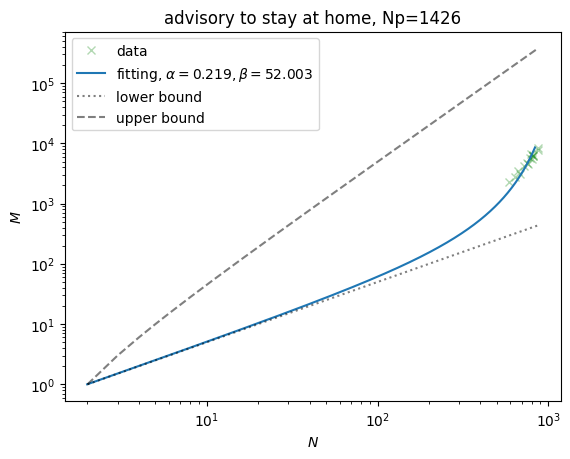

In [130]:
plt.Figure(figsize=(14,7))
N = lockdown_relax_1['node']
M = lockdown_relax_1['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.2, 0.8], maxfev=50000)
alpha = params[0]
beta = params[1]
plt.plot(Model3(y), y, "-", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("advisory to stay at home, Np="+str(Np))
plt.legend()

In [141]:
params = optimize.least_squares(residual3, [10, 20], args=(lockdown_relax_1["edge"], lockdown_relax_1["node"]), max_nfev=10000)
print(params)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.109e+01 -3.564e+00 ... -8.786e+00 -4.339e+01]
           x: [ 2.181e-01  2.907e+01]
        cost: 6313.980914344647
         jac: [[-1.738e+03  1.144e-01]
               [-1.725e+03  7.489e-02]
               ...
               [-1.670e+03  2.347e-01]
               [-1.577e+03  1.097e-01]]
        grad: [-9.108e+00  2.206e+00]
  optimality: 9.108409893417816
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 23
        njev: 7


In [139]:
params.x

array([ 0.21806379, 29.06641221])

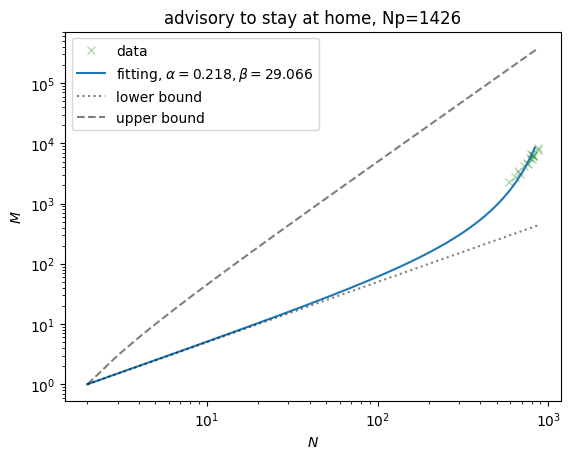

In [142]:
plt.Figure(figsize=(14,7))
N = lockdown_relax_1['node']
M = lockdown_relax_1['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
alpha = params.x[0]
beta = params.x[1]
plt.plot(Model3(y), y, "-", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("advisory to stay at home, Np="+str(Np))
plt.legend()

## 自宅待機勧告 12月

In [333]:
Np = 677 # histrical dataから求めたNp
params, _ = optimize.curve_fit(Model3_fixed, lockdown_relax_2['edge'], lockdown_relax_2['node'], p0=[0.5, 0.5])
print(params)

alpha = params[0]
beta = params[1]

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_50842/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


[ 0.32992123 21.3757665 ]


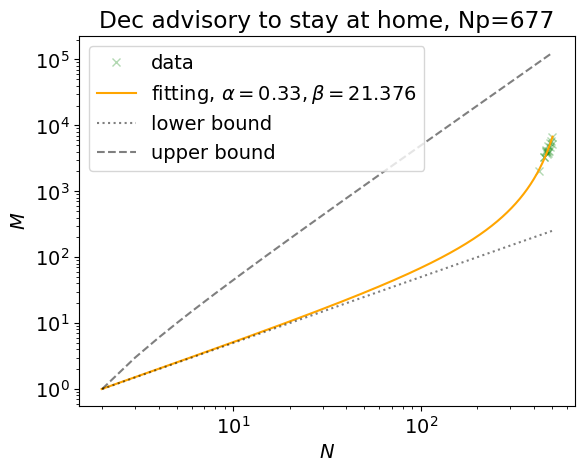

In [334]:
plt.Figure(figsize=(14,7))
N = lockdown_relax_2['node']
M = lockdown_relax_2['edge']

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")
"""
kappa = params[0]
kappa = round(kappa, 3)
plt.plot(Model1(y, kappa=kappa), y, "-", c="orange", label=f"fitting, $\\kappa={round(kappa, 3)}$")
"""

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("Dec advisory to stay at home, Np="+str(Np))
plt.legend()

In [ ]:
a = np.arange(0, 1, 0.01)
alpha = 0.471
beta = 9.707
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha,\beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"Lockdown", marker="o")

a = np.arange(0, 1, 0.01)
alpha = 0.351
beta = 5.337
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After Lockdown")


a = np.arange(0, 1, 0.01)
alpha = 0.33
beta = 21.376
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"Stay at home advisory Dec", marker=".")

a = np.arange(0, 1, 0.01)
alpha = 0.205
beta = 4.348
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2020/12/17 - 2021/12/31")

a = np.arange(0, 1, 0.01)
alpha = 0.114
beta = 8.175
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2022/1/1 - 2022/12/31", marker="v")

a = np.arange(0, 1, 0.01)
alpha = 0.219
beta = 46.105
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2023/1/1 - 2023/9/30", marker="s")


plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
plt.title("Activity distribution")
plt.legend()
plt.show()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/3427885254.py:2: RuntimeWarning: divide by zero encountered in power
  return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)


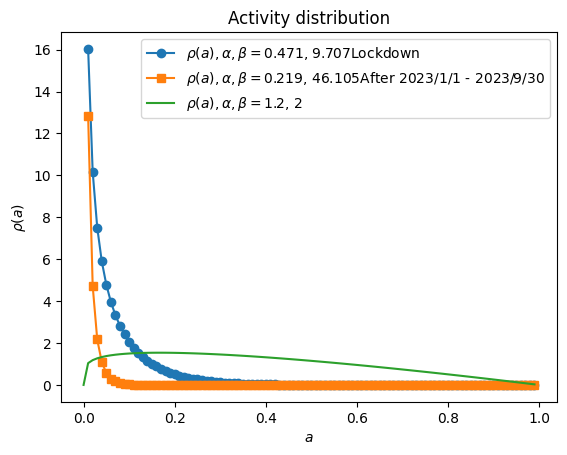

In [151]:

a = np.arange(0, 1, 0.01)
alpha = 0.471
beta = 9.707
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha,\beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"Lockdown", marker="o")

"""
a = np.arange(0, 1, 0.01)
alpha = 0.351
beta = 5.337
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After Lockdown")


a = np.arange(0, 1, 0.01)
alpha = 0.33
beta = 21.376
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"Stay at home advisory Dec", marker=".")

a = np.arange(0, 1, 0.01)
alpha = 0.205
beta = 4.348
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2020/12/17 - 2021/12/31")
"""
"""
a = np.arange(0, 1, 0.01)
alpha = 0.114
beta = 8.175
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2022/1/1 - 2022/12/31", marker="v")
"""
a = np.arange(0, 1, 0.01)
alpha = 0.219
beta = 46.105
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3))+"After 2023/1/1 - 2023/9/30", marker="s")

a = np.arange(0, 1, 0.01)
alpha = 1.2
beta = 2
plt.plot(a, rho(a, alpha, beta), label=r"$\rho(a), \alpha, \beta=$"+str(round(alpha, 3))+", "+str(round(beta, 3)))

plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
plt.title("Activity distribution")
plt.legend()
plt.show()

## 12月17日から2021年12月31日まで

In [94]:
# 2020/12/17~2021/12/31に分割
df_lockdown_relax_2020_2021 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-12-31")].dropna()
df_lockdown_relax_2020_2021.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
2979080,41.888716,-87.644448,TA1306000003,Desplaines St & Kinzie St,2020-12-27 12:55:06,member,70B6A9A437D4C30D,classic_bike,41.877726,-87.654787,13157,Aberdeen St & Jackson Blvd,2020-12-27 12:44:29,1.492156,"(41.87772613, -87.65478743)","(41.888716036, -87.6444478533)"
2979119,41.900129,-87.634448,TA1306000011,Wells St & Walton St,2020-12-18 14:01:46,member,15F369FDAED4E8E3,electric_bike,41.918112,-87.643799,TA1309000006,Larrabee St & Armitage Ave,2020-12-18 13:53:56,2.142780,"(41.91811233333333, -87.6437985)","(41.90012933333333, -87.63444766666667)"
2979130,41.889099,-87.642479,TA1306000003,Desplaines St & Kinzie St,2020-12-28 17:12:13,member,0CFD61DFE00E6043,electric_bike,41.889193,-87.638576,KA1503000043,Kingsbury St & Kinzie St,2020-12-28 17:10:25,0.324083,"(41.889193166666665, -87.63857616666667)","(41.889098833333335, -87.642479)"
2979168,41.889177,-87.638506,KA1503000043,Kingsbury St & Kinzie St,2020-12-20 13:15:08,member,B7AD5038F79637F9,classic_bike,41.881320,-87.629521,TA1305000006,Dearborn St & Monroe St,2020-12-20 13:09:04,1.147915,"(41.881319815, -87.6295209193)","(41.88917683258, -87.6385057718)"
2979212,41.967096,-87.667429,TA1309000014,Clark St & Leland Ave,2020-12-27 15:23:23,casual,890F28445C88F628,docked_bike,41.967096,-87.667429,TA1309000014,Clark St & Leland Ave,2020-12-27 14:42:25,0.000000,"(41.967096, -87.667429)","(41.967096, -87.667429)"


In [95]:
node, edge, timestamp = return_nm(df_lockdown_relax_2020_2021)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  p

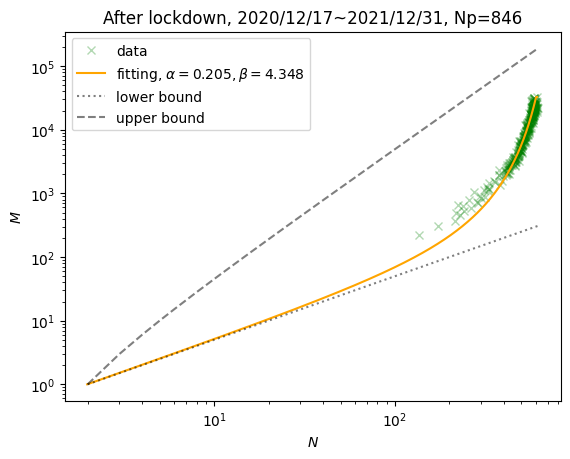

In [99]:
plt.Figure(figsize=(14,7))
N = node
M = edge

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

Np = 846 # histrical dataから求めたNp

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("After lockdown, 2020/12/17~2021/12/31, Np="+str(Np))
plt.legend()

## 2022/1/1~2022/12/31

In [104]:
# 2022/1/1~2022/12/31に分割
df_lockdown_relax_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2022-12-31")].dropna()
df_lockdown_relax_2022.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
3485010,41.889177,-87.638506,KA1503000043,Kingsbury St & Kinzie St,2022-03-21 13:51:18,member,47EC0A7F82E65D52,classic_bike,41.886875,-87.626030,TA1307000131,Wabash Ave & Wacker Pl,2022-03-21 13:45:01,1.066535,"(41.886875, -87.62603)","(41.88917683258, -87.6385057718)"
3485011,41.898203,-87.637536,620,Orleans St & Chestnut St (NEXT Apts),2022-03-16 09:43:34,member,8494861979B0F477,electric_bike,41.900998,-87.623752,13042,Michigan Ave & Oak St,2022-03-16 09:37:16,1.185206,"(41.90099766666667, -87.62375166666666)","(41.898203, -87.637536)"
3485012,41.984045,-87.660274,15578,Broadway & Ridge Ave,2022-03-23 19:54:48,member,EFE527AF80B66109,classic_bike,41.978353,-87.659753,13109,Broadway & Berwyn Ave,2022-03-23 19:52:02,0.633656,"(41.978353, -87.659753)","(41.9840446107, -87.6602738295)"
3485013,41.877708,-87.635321,TA1305000025,Franklin St & Jackson Blvd,2022-03-01 19:22:14,member,9F446FD9DEE3F389,classic_bike,41.886875,-87.626030,TA1307000131,Wabash Ave & Wacker Pl,2022-03-01 19:12:26,1.277286,"(41.886875, -87.62603)","(41.8777079559, -87.6353211408)"
3485014,41.877945,-87.662007,13206,Loomis St & Jackson Blvd,2022-03-21 19:19:11,member,431128AD9AFFEDC0,classic_bike,41.911722,-87.626804,LF-005,DuSable Lake Shore Dr & North Blvd,2022-03-21 18:37:01,4.754938,"(41.911722, -87.626804)","(41.877945, -87.662007)"


In [105]:
node, edge, timestamp = return_nm(df_lockdown_relax_2022)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  p

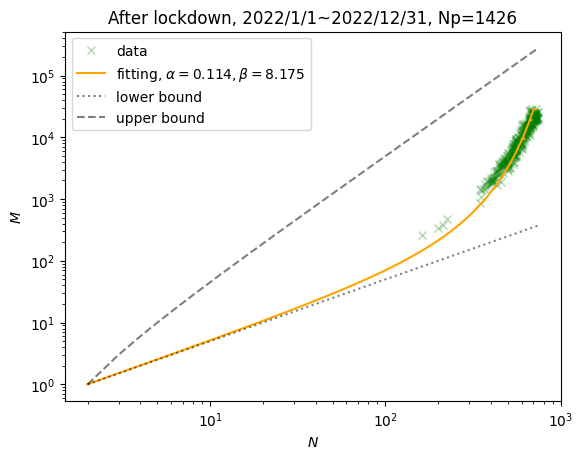

In [106]:
plt.Figure(figsize=(14,7))
N = node
M = edge

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

Np = 1426 # histrical dataから求めたNp

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("After lockdown, 2022/1/1~2022/12/31, Np="+str(Np))
plt.legend()

## 2023/1/1~2023/9/30

In [108]:
# 2022/1/1~2022/12/31に分割
df_lockdown_relax_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-12-31")].dropna()
node, edge, timestamp = return_nm(df_lockdown_relax_2023)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_67484/2291635319.py:7: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj, 0,1, args=(i))[0]


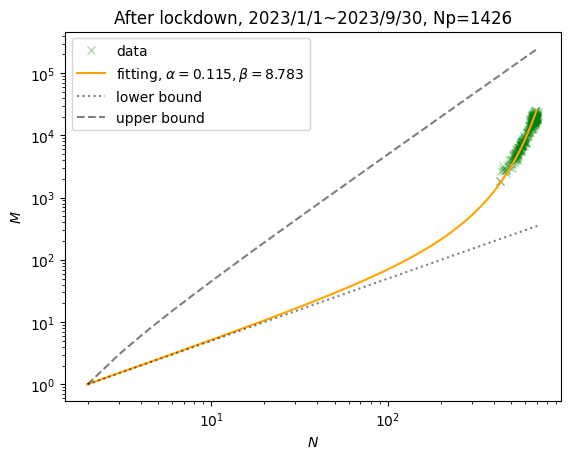

In [143]:
plt.Figure(figsize=(14,7))
N = node
M = edge

x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

Np = 1426 # histrical dataから求めたNp

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")


# model
plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("After lockdown, 2023/1/1~2023/9/30, Np="+str(Np))
plt.legend()